Bộ dữ liệu trong bài toán này liên quan đến các thông tin về bất động sản (real estate), đặc biệt là về các căn nhà ở Tehran. Các thuộc tính trong bộ dữ liệu này bao gồm:

* Area: Diện tích căn nhà
* Room: Số phòng trong căn nhà
* Parking: Có bãi đậu xe hay không
* Warehouse: Có kho chứa hay không
* Elevator: Có thang máy hay không
* Address: Địa chỉ căn nhà
* Price: Giá căn nhà
* Price (USD): Giá căn nhà tính bằng USD

Mục tiêu bài toán:
* Mục tiêu bài toán này có thể là dự đoán giá trị căn nhà dựa trên các đặc trưng như diện tích, số phòng, và các thông tin về thang máy, bãi đậu xe, v.v... Bài toán này có thể được áp dụng trong hệ thống dự báo giá bất động sản.



In [ ]:
!pip install -q seaborn

tải thư viện seaborn

In [5]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.17.0


import thư viện cần thiết để huấn luyện mô hình, in ra phiên bản thư viện

In [3]:
csv_file = '/content/TehranHouse.csv'

In [13]:
dataset = pd.read_csv(csv_file)

In [14]:
print(dataset.columns)

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')


Tạo danh sách tên cột một cách tự động, dựa trên các thuộc tính cho mỗi đặc trưng trong danh sách features

In [11]:
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

đọc dữ liệu trong dataset

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


đọc và in ra thông tin của dữ liệu

In [16]:
dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


lấy 5 hàng đầu tiên của dataset

In [18]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

dùng để tạo tập dữ liệu huấn luyện bằng cách lấy ngẫu nhiên 75% dữ liệu từ dataset

In [19]:
len(train_dataset)

2609

in ra chiều dài của tập dữ liệu

In [20]:
test_dataset = dataset.drop(train_dataset.index)

dừng để tạo tập dữ liệu kiểm tra bằng cách loại bỏ các hàng đã được chọn vào train_dataset ra khỏi dataset và tách dữ liệu thành hai phần không trùng nhau gồm 75% cho huấn luyện và 25% cho kiểm tra

In [21]:
len(test_dataset)

870

tính độ dài của tập dữ liệu kiểm tra

In [22]:
# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

chia tập dữ liệu huấn luyện và tập kiểm tra thành hai phần
- đặc trưng là các cột đầu dùng dự đoán kết quả được lưu trong x_train và x_test.
- nhãn là cootk kết quả được lưu trong y_train và y_test

In [27]:
x_train = x_train.drop(columns=['Parking'], errors='ignore')
x_test = x_test.drop(columns=['Parking'], errors='ignore')

In [26]:
print(x_train.columns)


Index(['Parking', 'Warehouse', 'Elevator', 'Price', 'Price(USD)'], dtype='object')


In [28]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

mã hóa nhãn thành số và chuyển đổi cả đầu vào x_train, x_test và nhãn y_train, y_test thành dạng Tensor để sẵn sàng cho quá trình huấn luyện

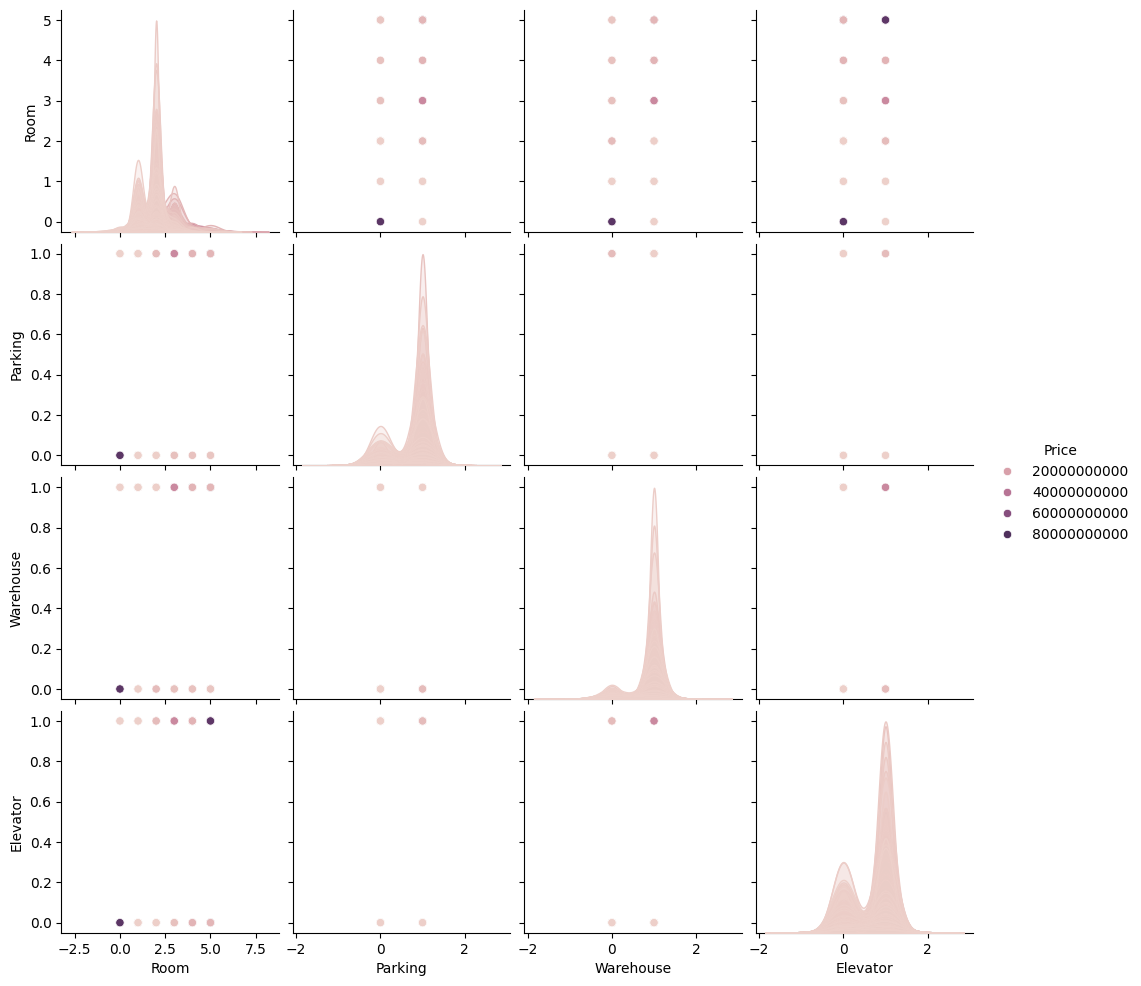

In [31]:
sns.pairplot(train_dataset[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Price']], hue='Price', diag_kind='kde')


chuyển đổi nhãn và dữ liệu đầu vào thành định dạng phù hợp để huấn luyện mô hình với TensorFlow

In [32]:
train_dataset.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
Room,2609.0,2.070908e+00,7.583588e-01,0.0,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00
Price,2609.0,5.328725e+09,8.112215e+09,3600000.0,1.420000e+09,2.880000e+09,5.990000e+09,9.240000e+10
Price(USD),2609.0,1.776242e+05,2.704072e+05,120.0,4.733333e+04,9.600000e+04,1.996667e+05,3.080000e+06


in 10 dòng của dữ liệu huấn luyện với các thuộc tính được liệt kê ở trên

In [33]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

chuẩn hóa cả hai dữ liệu(x_train và x_test) để tăng hiệu quả và độ chính xác

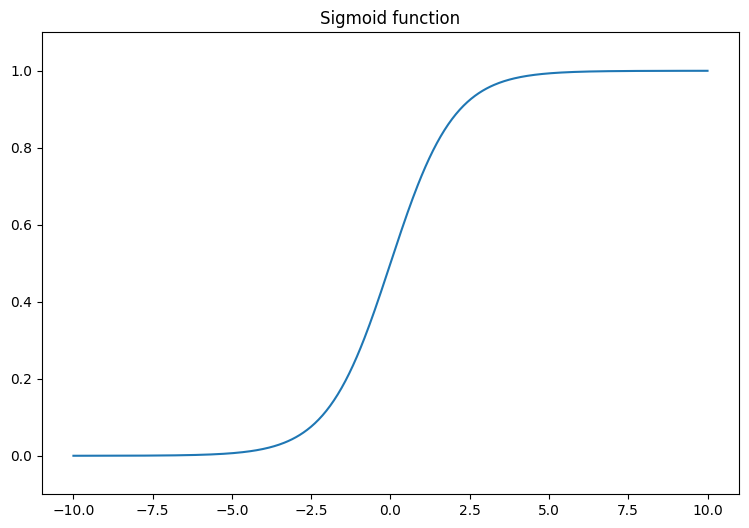

In [34]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

vẽ đồ thị của hàm sigmoid, với các giá trị đầu vào nằm trong khoảng từ -10 đến 10 và hiển thị trong trục y tử -0.1 đến 0.1

In [35]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

Tính toán log loss giữa giá trị dự đoán và nhãn thực tế, thường dùng trong phân loại nhị phân.

In [36]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

Lớp LogisticRegression định nghĩa mô hình hồi quy logistic:

Trong huấn luyện, tính toán đầu ra z.
Trong kiểm tra, tính xác suất lớp dương bằng hàm sigmoid.
Trọng số và độ lệch được khởi tạo ngẫu nhiên và có thể tối ưu hóa trong quá trình huấn luyện.

In [37]:
log_reg = LogisticRegression()

tạo một mô hình hồi quy logistic và lưu trữ nó trong biến log_reg

In [38]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.7364532 , 0.72246736, 0.22021286, 0.8598463 , 0.86254394],
      dtype=float32)

dòng lệnh này thực hiện dự đoán xác suất cho 5 mẫu đầu tiên trong tập dữ liệu x_train_norm và chuyển kết quả về định dạng NumPy

In [39]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

hàm predict_class chuyển giá trị xác suất thành lớp phân loại (0 hoặc 1) dựa trên ngưỡng thresh
hàm accuracy tính độ chính xác của mô hình bằng cách so sánh giá trị dự đoán với nhãn thực tế, tính toán tỷ lệ phần trăm chính xác

In [40]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

Chuyển các tập dữ liệu (x_train_norm, y_train, x_test_norm, y_test) thành đối tượng tf.data.Dataset.
Khuấy trộn dữ liệu để đảm bảo tính ngẫu nhiên.
Chia dữ liệu thành các batch với kích thước batch_size để cải thiện hiệu suất huấn luyện và kiểm tra.

In [41]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: nan
Epoch: 20, Training log loss: nan
Epoch: 40, Training log loss: nan
Epoch: 60, Training log loss: nan
Epoch: 80, Training log loss: nan
Epoch: 100, Training log loss: nan
Epoch: 120, Training log loss: nan
Epoch: 140, Training log loss: nan
Epoch: 160, Training log loss: nan
Epoch: 180, Training log loss: nan


Huấn luyện mô hình hồi quy logistic, tính toán và theo dõi mất mát, độ chính xác trong quá trình huấn luyện và kiểm tra. Các tham số được cập nhật sau mỗi batch, và kết quả được in ra mỗi 20 epoch để theo dõi tiến trình.

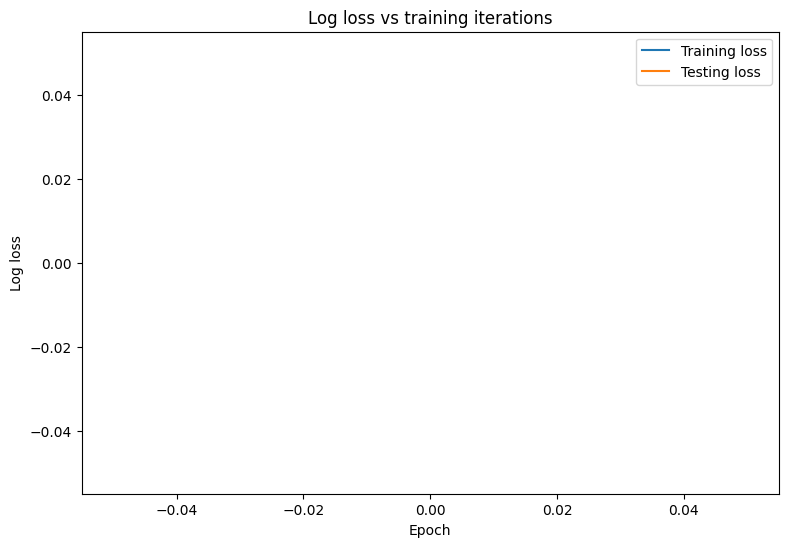

In [42]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

in ra sơ đồ mô hình huấn luyện và kiểm tra

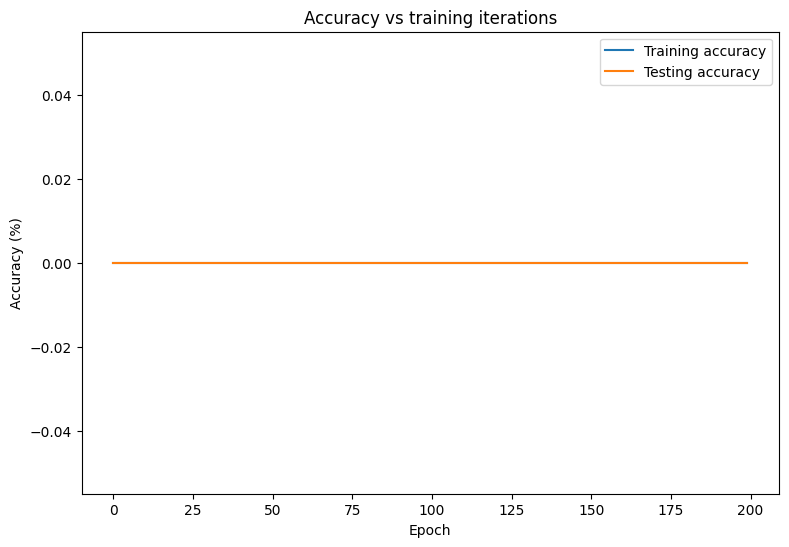

In [43]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [46]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

tính toán và hiển thị ma trận nhầm lẫn cho cả dữ liệu huấn luyện và kiểm tra
câc giá trị dự đoán được chuyển thành các lớp nhị phân sau đó tính toán và trực quan hóa ma trận nhầm lẫn để đánh giá hiêu suất của mô hình

in ra kết quả dự đoán từ mô hình huấn luyện

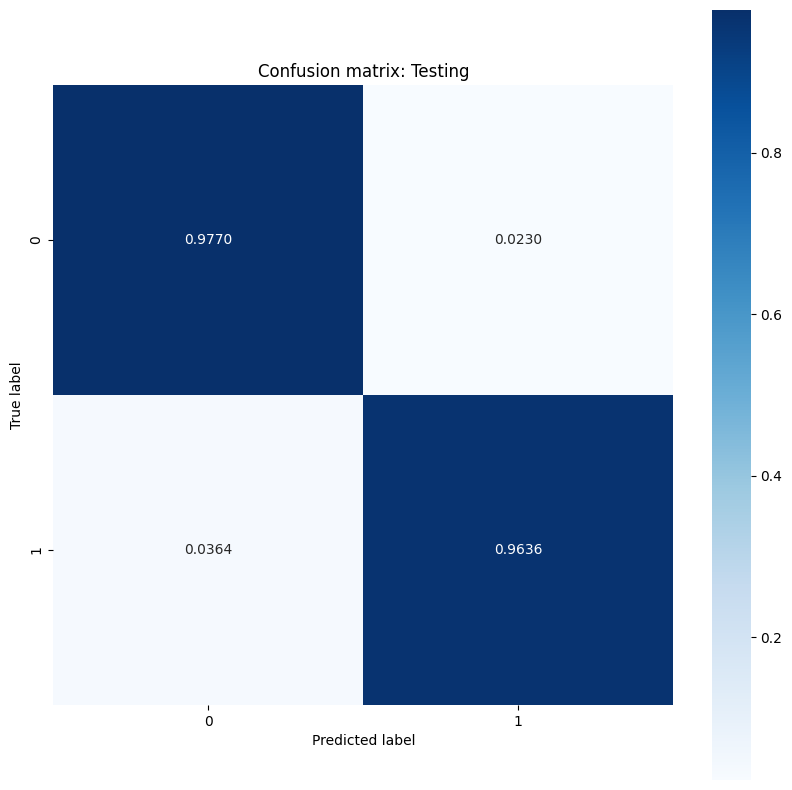

In [ ]:
show_confusion_matrix(y_test, test_classes, 'Testing')

in ra kết quả dự đoán của mô hình kiểm tra

In [ ]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

Lớp ExportModule tổ chức các bước tiền xử lý, dự đoán và hậu xử lý thành một module duy nhất, giúp dự đoán dữ liệu mới mà không cần lo về chi tiết tiền xử lý, làm việc triển khai mô hình dễ dàng hơn.

In [ ]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

log_reg_export là đối tượng giúp dự đoán dữ liệu mới, thực hiện chuẩn hóa, sử dụng mô hình dự đoán và chuyển kết quả thành lớp nhị phân, đóng gói các bước tiền xử lý và hậu xử lý.

In [ ]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

Lưu mô hình log_reg_export vào thư mục tạm thời dưới dạng SavedModel, giúp tái sử dụng mô hình đã huấn luyện và dễ dàng triển khai trong môi trường sản xuất. Sau khi lưu, có thể tải lại mô hình để dự đoán dữ liệu mới mà không cần khôi phục tham số huấn luyện.

In [ ]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)

Bài toán này hướng tới việc sử dụng mô hình hồi quy logistic để dự đoán giá trị bất động sản dựa trên các đặc trưng của căn nhà.